In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch
from torch import vmap
import caustics
from IPython.display import HTML


In [2]:
cosmology = caustics.FlatLambdaCDM()
sie = caustics.Point(cosmology=cosmology, name='lens')
# src = caustics.Sersic(name='source')
src = caustics.PointSource(name='source')

In [13]:
n_pix = 100
res = 0.05
upsample_factor = 10
theta_x, theta_y = caustics.utils.meshgrid(
    res / upsample_factor,
    upsample_factor * n_pix,
    dtype=torch.float32,
)

In [14]:
class Microlens(caustics.Simulator):
    def __init__(
            self,
            lens,
            src,
            theta_x=None,
            theta_y=None,
            z_s=None,
            lightcurve=False,
            name: str = "sim"
    ):
        super().__init__(name)
        self.lens = lens
        self.src = src
        self.lightcurve = lightcurve

        self.add_param("theta_x", theta_x)
        self.add_param('theta_y', theta_y)
        self.add_param("z_s", z_s)


    def forward(self, params):
        theta_x, theta_y, z_s = self.unpack(params)
        beta_x, beta_y = self.lens.raytrace(theta_x, theta_y, z_s, params)
        brightness = self.src.brightness(beta_x, beta_y, params)

        if self.lightcurve:
            baseline_brightness = self.src.brightness(theta_x, theta_y, params)
            return brightness.mean()/baseline_brightness.mean()

        return brightness


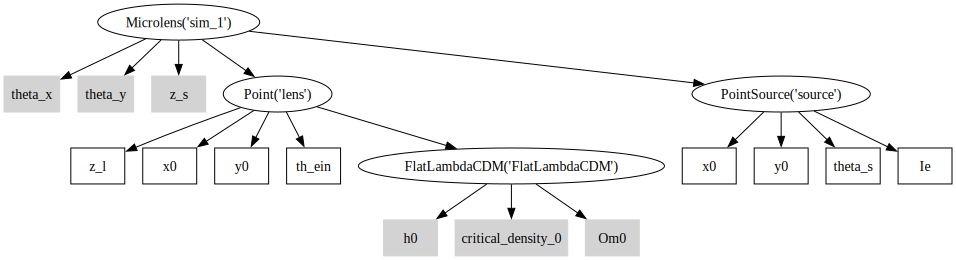

In [15]:
sim = Microlens(sie, src, theta_x=theta_x, theta_y=theta_y, z_s=0.0)
sim.graph(True,True)

In [16]:
sim.x_order

['lens.z_l',
 'lens.x0',
 'lens.y0',
 'lens.th_ein',
 'source.x0',
 'source.y0',
 'source.theta_s',
 'source.Ie']

In [45]:
x = torch.tensor([
    #    z_l  x0   y0  th_ein x0   y0  theta_s, Ie
         0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 1.0,    5.0
    ])  

In [54]:
B=64 #Batch size
newx = x.repeat(B, 1)
x0s = torch.linspace(-3, 3, B).view(-1, 1)  # Shape is [B, 1]
y0s = torch.zeros_like(x0s)
newx[:,1] = x0s.view(-1)
newx[:,2] = y0s.view(-1)

In [55]:
sim.lightcurve = False #Return images
images = torch.vmap(sim)(newx) 

In [56]:
ts = torch.linspace(-1,1,B).view(-1,1) #Create dummy time variables
sim.lightcurve = True #Return normalized flux counts
magnifications = torch.vmap(sim)(newx) 

In [63]:
# Set up the figure and two subplots
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(6, 8))

# Display the first frame of the image in the first subplot
img = ax1.imshow(images[0].numpy(), cmap='cividis', interpolation='none')
ax1.set_title('Image')

# Set up the scatter plot for magnifications in the second subplot
scatter = ax2.scatter(ts[0].item(), magnifications[0].item())
ax2.set_xlim(ts.min().item(), ts.max().item())
ax2.set_ylim(magnifications.min().item()*0.9, magnifications.max().item()*1.1)
ax2.set_xlabel('t')
ax2.set_ylabel('A')

def update(frame):
    """Update function for the animation."""
    # Update the image in the first subplot
    img.set_array(images[frame].numpy())

    # Update the scatter plot in the second subplot
    ax2.clear()  # Clear the previous frame
    ax2.scatter(ts[:frame+1].numpy(), magnifications[:frame+1].numpy())
    ax2.set_xlim(ts.min().item(), ts.max().item())
    ax2.set_ylim(magnifications.min().item()*0.9, magnifications.max().item()*1.1)
    ax2.set_xlabel('t')
    ax2.set_ylabel('A')
    ax2.set_title('Magnification')

    return img, scatter

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=B, interval=60)

plt.close()

#Save animation
# ani.save("microlensing_animation.gif", writer='pillow', fps=16)  # Adjust 'fps' for the speed

# Display the animation inline
HTML(ani.to_jshtml())